In [1]:
# https://github.com/Suzehva/time_in_language_models_current/blob/main/ii_accuracy/ii_accuracy.py

In [2]:
import numpy as np
import random
import torch

def set_seed(seed):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)

set_seed(0)

device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")

## Create all prompts where interchanging should cause the model to switch tenses (past/present/future)

In [3]:
# from transformers import AutoConfig, AutoModelForCausalLM, AutoTokenizer

model_id = "allenai/OLMo-2-0425-1B"
revision = None

DATA_DIR = f'/nlp/scr/suzeva/data'
MODEL_DIR = '/nlp/scr/suzeva/models'


In [4]:
# from generation_utils import generate_batched

# prompt_template = 'In {year} there'
# prompts = [prompt_template[0].format(year=year) for year in range(1950, 2050)]
# prompt_to_output = generate_batched(model, tokenizer, prompts, max_new_tokens=1)

# base_source_prompts = 



## Heatmap with one prompt
    

In [5]:
# from interchange_intervention import InterchangeIntervention
# ii_olmo = InterchangeIntervention(model_id=model_id, folder_path="heatmap_results")
# base_prompt = "In 1980 there"
# source_prompt = "In 2050 there"
# base_src_pairs = [(base_prompt, [source_prompt])]
# output_to_measure = [" was", " is", " will"]
# base_token_of_interest= "1980"
# source_token_of_interest = "2050"
# df_intervention_data_list = ii_olmo.generate_csvs_accuracy(base_src_pairs, output_to_measure, base_token_of_interest=base_token_of_interest)
# running_col_avg = ii_olmo.compute_accuracy(base_src_pairs, df_intervention_data_list, base_token_of_interest=base_token_of_interest, source_token_of_interest=source_token_of_interest) 
# ii_olmo.plot_accuracy(running_col_avg, base_label=base_token_of_interest, source_label=source_token_of_interest, filename=f"{base_prompt.replace(' ', '_')}<--{source_prompt.replace(' ', '_')}", token_order=output_to_measure)


In [6]:
import pandas as pd
import pyvene
from pyvene import embed_to_distrib, top_vals, format_token
from pyvene import RepresentationConfig, IntervenableConfig, IntervenableModel
from pyvene import VanillaIntervention

%config InlineBackend.figure_formats = ['svg']
from plotnine import (
    ggplot,
    geom_tile,
    aes,
    facet_wrap,
    theme,
    element_text,
    geom_bar,
    geom_hline,
    scale_y_log10,
)

config, tokenizer, olmo = pyvene.create_olmo2(name="allenai/OLMo-2-0425-1B")


nnsight is not detected. Please install via 'pip install nnsight' for nnsight backend.


`torch_dtype` is deprecated! Use `dtype` instead!


Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

loaded model


In [12]:

def simple_position_config(model_type, component, layer):
    config = IntervenableConfig(
        model_type=model_type,
        representations=[
            RepresentationConfig(
                layer,              # layer
                component,          # component
                "pos",              # intervention unit
                1,                  # max number of unit
            ),
        ],
        intervention_types=VanillaIntervention,
    )
    return config


base = tokenizer("The capital of Spain is", return_tensors="pt")
sources = [tokenizer("The capital of Italy is", return_tensors="pt")]
tokens = tokenizer.encode(" Madrid Rome")
data = []

for layer_i in range(olmo.config.num_hidden_layers):
    config = simple_position_config(type(olmo), "mlp_output", layer_i) # TODO don't use MLP
    intervenable = IntervenableModel(config, olmo)
    for pos_i in range(len(base.input_ids[0])):
        
        _, counterfactual_outputs = intervenable(
            base, sources, {"sources->base": pos_i}
        )
        logits = counterfactual_outputs.logits
        distrib = torch.softmax(logits, dim=-1)
        # distrib = embed_to_distrib(
        #     olmo, counterfactual_outputs.hidden_states[-1], logits=False
        # )
        for token in tokens:
            data.append(
                {
                    "token": format_token(tokenizer, token),
                    "prob": float(distrib[0][-1][token]),
                    "layer": f"f{layer_i}",
                    "pos": pos_i,
                    "type": "mlp_output",
                }
            )

    config = simple_position_config(type(olmo), "attention_input", layer_i)
    intervenable = IntervenableModel(config, olmo)
    for pos_i in range(len(base.input_ids[0])):
        _, counterfactual_outputs = intervenable(
            base, sources, {"sources->base": pos_i}
        )
        logits = counterfactual_outputs.logits
        distrib = torch.softmax(logits, dim=-1)
        # distrib = embed_to_distrib(
        #     olmo, counterfactual_outputs.hidden_states[-1], logits=False
        # )
        for token in tokens:
            data.append(
                {
                    "token": format_token(tokenizer, token),
                    "prob": float(distrib[0][-1][token]),
                    "layer": f"a{layer_i}",
                    "pos": pos_i,
                    "type": "attention_input",
                }
            )
df = pd.DataFrame(data)

/tmp/user/23870/ipykernel_4071010/64062854.py:15: FutureWarning: Using print(plot) to draw and show the plot figure is deprecated and will be removed in a future version. Use plot.show().


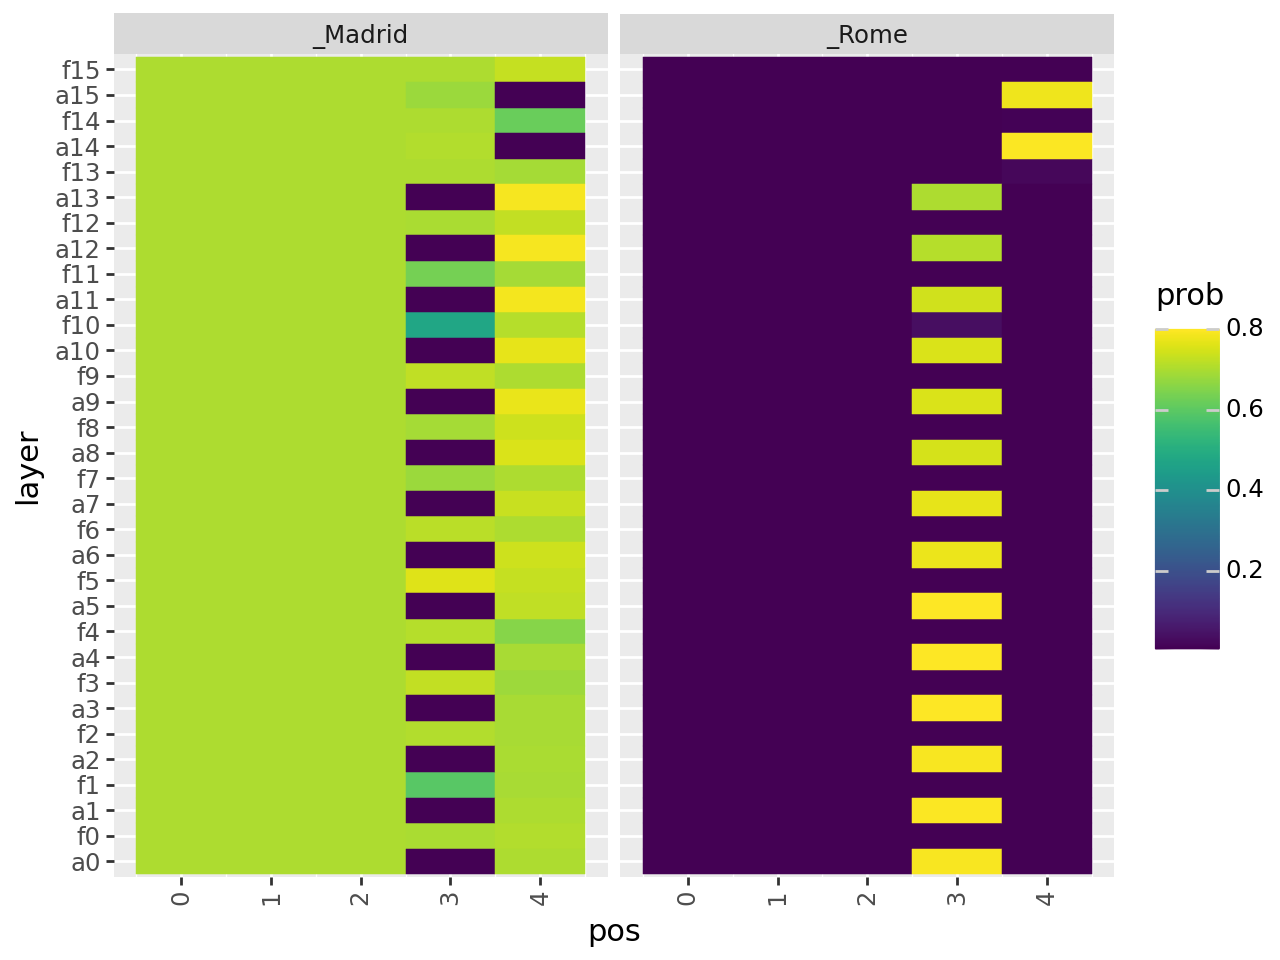

In [15]:
df["layer"] = df["layer"].astype("category")
df["token"] = df["token"].astype("category")
nodes = []
for l in range(olmo.config.num_hidden_layers - 1, -1, -1):
    nodes.append(f"f{l}")
    nodes.append(f"a{l}")
df["layer"] = pd.Categorical(df["layer"], categories=nodes[::-1], ordered=True)

g = (
    ggplot(df)
    + geom_tile(aes(x="pos", y="layer", fill="prob", color="prob"))
    + facet_wrap("~token")
    + theme(axis_text_x=element_text(rotation=90))
)
print(g)